# 5.多元高斯

多维度下的不确定性建模

In [4]:
%matplotlib inline

In [5]:
#format the book
import book_format
book_format.set_style()

# 简介

上一章的技术非常强大，但它们只适用于一个变量或维度。它们没有办法表示多维数据，比如一只狗在场地上的位置和速度。位置和速度彼此相关，正如我们在 g-h 章节学到的，我们不应该丢失信息。在这一章中，我们将学习如何以概率的方式描述这种关系。通过这个关键的洞察，我们将会取得明显更好的滤波器性能。

# 多元正态分布

在前面的章节中，我们使用了高斯分布来表示一个标量随机变量，表达为 $\mathcal{N}(\mu, \sigma^2)$。这的更正式术语是 *单变量正态分布*，其中“单变量”意味着“一个变量”。高斯分布的概率分布被称为 *单变量正态分布*。

那么，*多变量正态分布*会是什么样子呢？*多变量*意味着多个变量。我们的目标是能够表示具有多个维度的正态分布。我并不一定指空间维度——如果我们追踪飞机在 (x, y, z) 上的位置、速度和加速度，这将给我们一个九维问题。考虑一个二维情况。它可能是机器人的 *x* 和 *y* 坐标，也可能是狗在 x 轴上的位置和速度，或者是奶牛场的产奶量和饲料速率。实际上并不重要。我们可以看到，对于 $N$ 个维度，我们需要 $N$ 个均值，我们会将它们排列成一个列矩阵（向量），如下所示：

$$
\mu = \begin{bmatrix}\mu_1\\\mu_2\\ \vdots \\\mu_n\end{bmatrix}
$$

假设我们相信 $x = 2$ 且 $y = 17$。我们会得到

$$
\mu = \begin{bmatrix}2\\17\end{bmatrix} 
$$

下一步是表示我们的方差。乍一看，我们可能会认为我们对于 N 个维度也需要 N 个方差。我们可能想说 x 的方差是 10，y 的方差是 4，如下所示。

$$\sigma^2 = \begin{bmatrix}10\\4\end{bmatrix}$$ 

这是不完整的，因为它没有考虑更一般的情况。在**高斯分布**章节中，我们计算了学生身高的方差。这是一种衡量他们身高相对差异的方式。如果所有学生身高都相同，方差就是 0；如果他们的身高差异很大，方差就会很大。

身高和体重之间也存在着关系。一般来说，个子高的人比个子矮的人体重更重。身高和体重是 *相关* 的。我们想要一种方法来表示我们对身高和体重的方差以及它们之间关联程度的看法。换句话说，我们想知道体重相对于身高的变化程度。我们称之为 *协方差*。

在理解多变量正态分布之前，我们需要了解相关性和协方差背后的数学原理。

# 相关性和协方差

协方差描述了两个变量一起变化的程度。它是 *相关方差* 的简称。换句话说，*方差* 衡量了一个群体内部变化的程度，而 *协方差* 则衡量了两个变量相对于彼此的变化程度。例如，身高增加时体重通常也会增加。这些变量是 *相关* 的。它们是 *正相关* 的，因为一个变量增加时另一个也会增加。而室外温度下降时家庭供暖费用会增加。这些是 *负相关* 的，因为一个变量增加时另一个变量减少。茶叶价格和我家狗摇尾巴的次数之间没有关系，我们称它们是 *无关联* 的或 *独立* 的——它们各自可以独立变化，不受对方影响。

相关性有助于预测。如果你比我高很多，我可以预测你的体重也比我重。随着冬天的来临，我预计会花更多钱来供暖。但如果我的狗摇尾巴的次数增加，我不会得出茶叶价格会变化的结论。

举个例子，这里有一张学校田径队学生身高和体重的图表。如果一个学生身高是68英寸，我可以预测他们大约体重160磅。但由于相关性并非完美，所以我的预测也就不完全准确。

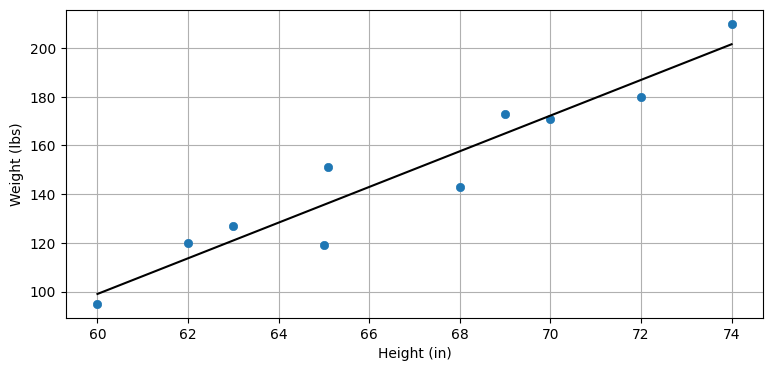

In [7]:
from kf_book.gaussian_internal import plot_correlated_data

height = [60, 62, 63, 65, 65.1, 68, 69, 70, 72, 74]
weight = [95, 120, 127, 119, 151, 143, 173, 171, 180, 210]
plot_correlated_data(height, weight, 'Height (in)', 'Weight (lbs)', False)

在这本书中，我们只考虑 *线性相关性*。我们假设变量之间的关系是线性的，也就是说，直线是数据的一个很好的拟合线。我已经在上面的图表中拟合了一条直线。*非线性相关性* 的概念确实存在，但我们不会使用它。

$X$ 和 $Y$ 之间协方差的方程是

$$ COV(X, Y) = \sigma_{xy} = \mathbb E\big[(X-\mu_x)(Y-\mu_y)\big]$$

这里的 $\mathbb E[X]$ 是 $X$ 的 *期望值*，定义为

$$\mathbb E[X] =  \begin{cases} \sum_{i=1}^n p_ix_i & \mbox{离散情况}\\ \int_{-\infty}^\infty f(x)\, x dx & \mbox{连续情况}\end{cases}$$

我们假设每个数据点的发生概率相同，所以每个数据点的概率是 $\frac{1}{N}$，因此在我们考虑的离散情况下，期望值可以表示为

$$\mathbb E[X] =  \frac{1}{N}\sum_{i=1}^n x_i$$

将协方差方程与方差方程进行比较，可以看到它们非常相似：

$$\begin{aligned}VAR(X) = \sigma_x^2 &= \mathbb E[(X - \mu)^2]\\
COV(X, Y) = \sigma_{xy} &= \mathbb E\big[(X-\mu_x)(Y-\mu_y)\big]\end{aligned}$$

特别是，如果你计算 $COV(X, X)$，你会得到 $VAR(X)$ 的方程，这支持了我的观点，即方差计算了随机变量在自身之间的变化程度。

我们使用 *协方差矩阵* 表示多元正态分布的协方差，它的形式如下：
$$
\Sigma = \begin{bmatrix}
  \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
  \sigma_{21} &\sigma_2^2 & \cdots & \sigma_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_n^2
 \end{bmatrix}
$$

对角线包含每个变量的方差，非对角线元素包含第 $i$ 和第 $j$ 个变量之间的协方差。因此，$\sigma_3^2$ 是第三个变量的方差，$\sigma_{13}$ 是第一和第三个变量之间的协方差。

协方差为 0 表示没有相关性。如果 $x$ 的方差是 10，$y$ 的方差是 4，并且 $x$ 和 $y$ 之间没有线性相关性，那么我们可以写成

$$\Sigma = \begin{bmatrix}10&0\\0&4\end{bmatrix}$$

如果 $x$ 和 $y$ 之间有一小部分正相关，我们可能有

$$\Sigma = \begin{bmatrix}10&1.2\\1.2&4\end{bmatrix}$$

这里的 1.2 是 $x$ 和 $y$ 之间的协方差。我说相关性是 "小" 是因为 1.2 相对于方差 10 来说是较小的协方差。

如果 $x$ 和 $y$ 之间有大量的负相关性，我们可能有

$$\Sigma = \begin{bmatrix}10&-9.7\\-9.7&4\end{bmatrix}$$

协方差矩阵是对称的。毕竟，$x$ 和 $y$ 之间的协方差始终等于 $y$ 和 $x$ 之间的协方差。也就是说，对于任何 $x$ 和 $y$，$\sigma_{xy}=\sigma_{yx}$。

让我们回顾一下。在**高斯分布**章节中，我们有一组学生的身高数据 H=[1.8, 2.0, 1.7, 1.9, 1.6] 米。我们计算了：

$$\begin{aligned}
\mathit{VAR}(H) &= E[(H - \mu_H)^2] \\
&= \frac{1}{N}\sum_{i=1}^n (H_i - \mu_H)^2 \\
&= \frac{1}{5}\left[(1.8-1.8)^2 + (2-1.8)^2 + (1.7-1.8)^2 + (1.9-1.8)^2 + (1.6-1.8)^2\right] \\
&= 0.02
\end{aligned}$$

这里的 $\mathit{VAR}(H)$ 表示学生身高的方差，计算结果是 0.02 米。

没错，这里要做的是计算身高和体重的协方差矩阵。根据给出的方程：

$$\Sigma = \begin{bmatrix}\sigma_H^2 & \sigma_{H,W} \\
\sigma_{W,H} & \sigma_{W}^2\end{bmatrix}$$

我们已经计算了身高的方差，它将放在矩阵的左上角。矩阵的右下角包含了体重的方差。使用相同的方程，我们得到：

$$\begin{aligned}
\mu_W &= \frac{1}{5}(70.1 + 91.2 + 59.5 + 93.2 + 53.5) = 73.5 \\
\sigma_W^2 &= \frac{1}{5}\left[(70.1-73.5)^2 + (91.2-73.5)^2 + (59.5-73.5)^2 + (93.2-73.5)^2 + (53.5-73.5)^2\right] \\
&= 261.8
\end{aligned}$$

现在是协方差的计算。使用上面的公式，我们计算：

$$\begin{aligned}
\sigma_{H,W} &= \mathbb E\big[(H-\mu_H)(W-\mu_W)\big] \\
&= \frac{1}{N}\sum_{i=1}^n (H_i-\mu_H)(W_i-\mu_W) \\
&= \frac{1}{5}[(1.8-1.8)(70.1-73.5) + (2-1.8)(91.2-73.5) + (1.7-1.8)(59.5-73.5) +\\
&\, \, \, \,  \, (1.9-1.8)(93.2-73.5) + (1.6-1.8)(53.5-73.5)] \\
&= 2.18
\end{aligned}$$

虽然有些繁琐，但还是挺简单的。我们以后不会再这样做了，因为当然，NumPy可以为我们计算这些。

In [8]:
import numpy as np

W = [70.1, 91.2, 59.5, 93.2, 53.5]
H = [1.8, 2.0, 1.7, 1.9, 1.6]
np.cov(H, W)

array([[  0.025,   2.727],
       [  2.727, 327.235]])

没错，这并不是我们计算的结果出错了。NumPy对于小样本大小会进行修正；它使用的是 $\frac{1}{N-1}$ 作为归一化项，而不是 $\frac{1}{N}$。

这已经超出了本书的范围。简单来说，假设实际班级大小是 200 名学生，但由于我们无法测量和称量所有 200 名学生，我们只从中取了 5 名学生的样本来进行计算。很可能我们的估计会有一些误差，因为样本不太可能完美地代表整个班级。随着样本量接近 200，误差会接近于 0。我们说后者没有*偏差*，我们有一个*无偏估计器*。相比之下，当我们取一个小样本时，会有偏差（误差不为零），我们有一个*有偏估计器*。

如果误差为零，按照 $N$ 进行除是有意义的。我不会证明为什么，但对于有偏估计器，我们使用 $\frac{1}{N-1}$ 来校正小样本量。NumPy默认使用这种方式，因为实际上我们几乎总是从更大的集合中获取数据样本。如果你想要无偏估计，就像我们上面计算的那样，请在调用 `np.cov` 时使用 `bias=1`。

当 bias=True（默认值）时，它使用 $N$ 来归一化协方差矩阵。这种情况下，协方差计算公式为：$\frac{1}{N} \cdot (X - X_{mean})^T \cdot (X - X_{mean})$。

当 bias=False 时，它使用 $N-1$ 来归一化协方差矩阵。这种情况下，协方差计算公式为：$\frac{1}{N-1} \cdot (X - X_{mean})^T \cdot (X - X_{mean})$。这个修正主要用于样本方差/协方差的无偏估计。

In [9]:
np.cov(H, W, bias=1)

array([[  0.02 ,   2.182],
       [  2.182, 261.788]])

这个计算结果与我们的计算一致。在本书中，我们将不再使用 `bias=1`，因为我们使用的是 *随机变量*，它们是从我们正在跟踪的物体的无限位置集合中进行抽样。在这里，我们计算的是整个群体的方差和协方差，所以 `bias=1` 是正确的。

这个矩阵告诉我们什么？它告诉我们身高的方差是 0.02 $m^2$，体重的方差是 261.788 $kg^2$。此外，它告诉我们体重和身高是正相关的——随着身高的增加，体重也增加。

让我们创建完全相关的数据。我的意思是数据完全符合一条直线——不会有与该直线偏离的方差。

In [10]:
X = np.linspace(1, 10, 100)
Y = np.linspace(1, 10, 100)
np.cov(X, Y)

array([[6.956, 6.956],
       [6.956, 6.956]])

从协方差矩阵中我们可以看出，协方差等于$x$和$y$的方差。

现在让我们给其中一个变量添加一些噪音，这样它们就不再完全相关了。我将会使$Y$变成负数，制造一个负相关。

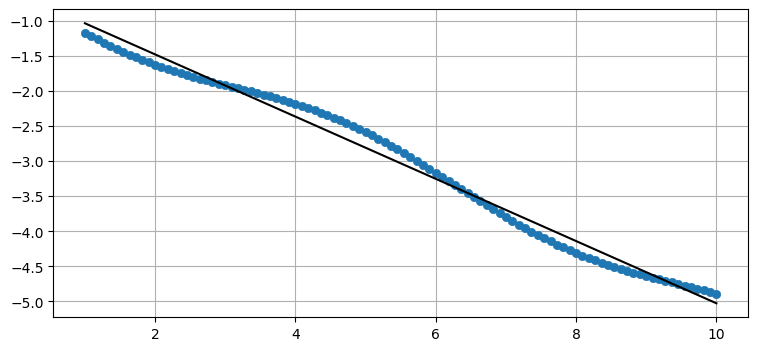

[[ 6.956 -3.084]
 [-3.084  1.387]]


In [11]:
X = np.linspace(1, 10, 100)
Y = -(np.linspace(1, 5, 100) + np.sin(X)*.2)
plot_correlated_data(X, Y)
print(np.cov(X, Y))

数据不再呈现出一条直线。协方差是 $\sigma_{xy}=-3.08$。与 $\sigma_x^2$ 和 $\sigma_y^2$ 的数量级相比，这个值并不接近零，所以我们知道仍然存在着高度的相关性。我们可以通过观察图表来验证这一点。数据几乎呈现出一条直线。

现在我会在一条直线上添加随机噪音。

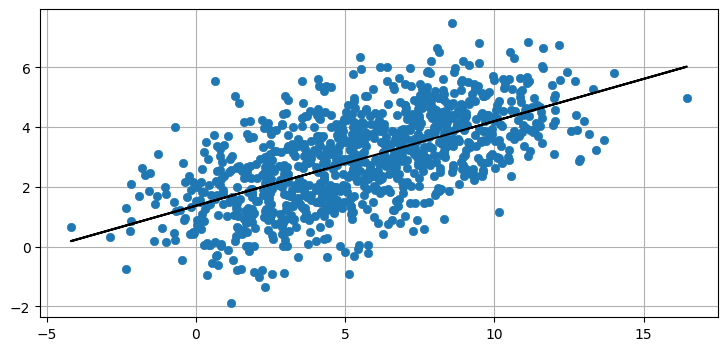

[[11.05   3.13 ]
 [ 3.13   2.431]]


In [12]:
from numpy.random import randn
X = np.linspace(1, 10, 1000) + randn(1000)*2
Y = np.linspace(1, 5, 1000) + randn(1000)
plot_correlated_data(X, Y)
print(np.cov(X, Y))

我们看到协方差相对于方差要小一些，反映了$X$和$Y$之间较低的相关性。我们仍然可以通过这些数据拟合一条直线，但数据的变化要大得多。

最后，这是完全随机数据之间的协方差。

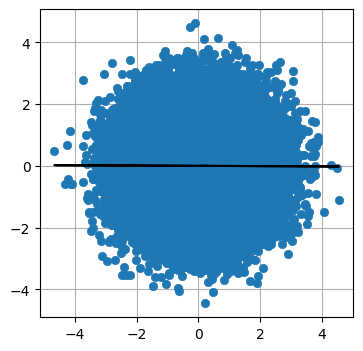

[[ 0.999 -0.004]
 [-0.004  0.997]]


In [13]:
X = randn(100000)
Y = randn(100000)
plot_correlated_data(X, Y)
print(np.cov(X, Y))

在这里，协方差非常接近零。正如您在图中所看到的，没有明显的方法可以画一条拟合数据的直线。一条垂直的线和我展示的水平线一样站不住脚。

# 多元正态分布方程

回顾一下**高斯分布**章节中正态分布的方程：

$$ 
f(x, \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \Big [{-\frac{1}{2}}{(x-\mu)^2}/\sigma^2 \Big ]
$$

这是 $n$ 维中的多元正态分布方程。

$$
f(\mathbf{x},\, \mu,\,\Sigma) = \frac{1}{\sqrt{(2\pi)^n|\Sigma|}}\, \exp  \Big [{ -\frac{1}{2}(\mathbf{x}-\mu)^\mathsf{T}\Sigma^{-1}(\mathbf{x}-\mu) \Big ]}
$$

多元版本仅仅用矩阵取代了单变量方程中的标量。如果你对线性代数比较熟悉，这个方程看起来应该是相当容易理解的。如果不是，别担心，FilterPy 和 SciPy 都提供了计算的函数。让我们暂时忽略计算，先来绘制一下它的图像看看。

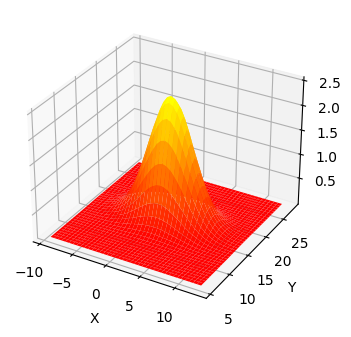

In [14]:
import kf_book.mkf_internal as mkf_internal

mean = [2., 17.]
cov = [[10., 0.], 
       [0., 4.]]

mkf_internal.plot_3d_covariance(mean, cov)

这是一个均值为 $\mu=[\begin{smallmatrix}2\\17\end{smallmatrix}]$，协方差为 $\Sigma=[\begin{smallmatrix}10&0\\0&4\end{smallmatrix}]$ 的多元高斯分布的图表。这个三维形状展示了在 z 轴上 $(X, Y)$ 的任何值的概率密度。我将 $x$ 和 $y$ 的方差投影到了图表的墙壁上——你可以看到它们呈现出高斯钟形曲线的形状。$X$ 的曲线比 $Y$ 的曲线更宽，这可以用 $\sigma_x^2=10$ 和 $\sigma_y^2=4$ 来解释。这个三维表面的最高点在 $X$ 和 $Y$ 的均值处。

所有的多元高斯分布都具有这种形状。如果我们将其视为描述狗的位置的高斯分布，那么在 ($X, Y$) 的每个点处的 z 值就是狗在那个位置的概率密度。严格来说，这是*联合概率密度函数*，我马上会定义它。所以，狗最有可能在 (2, 17) 附近，可能性稍低在 (5, 14) 附近，而在 (10, 10) 附近的可能性非常低。与单变量情况一样，这是一个*概率密度*，而不是*概率*。连续分布具有无限的范围，因此恰好在 (2, 17) 或任何其他点的概率都是 0%。我们可以通过积分计算曲面下的体积来计算落在给定范围内的概率。

FilterPy [2]在`filterpy.stats`模块中使用`multivariate_gaussian()`函数实现了这个方程。而SciPy的`stats`模块使用`multivariate_normal()`来实现多元正态分布方程。它实现了一个“冻结”的形式，你可以一次设置均值和协方差，然后在任意数量的调用中计算x的任意数量的值的概率密度。我将我的函数命名为`multivariate_gaussian()`，以确保它永远不会与SciPy的版本混淆。

> `scipy.stats` 模块的<a href="http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html">教程</a>[1]解释了“冻结”分布和其他非常有用的功能。

In [15]:
from filterpy.stats import gaussian, multivariate_gaussian

首先，让我们找到狗在 (2, 7) 的情况下，$x$ 的方差为 8，$y$ 的方差为 3 时，它在 (2.5, 7.3) 处的概率密度。

先将 $x$ 设置为 (2.5, 7.3)。你可以使用元组、列表或 NumPy 数组。

In [16]:
x = [2.5, 7.3]

然后，设置均值：

In [18]:
mu = [2.0, 7.0]

最后，我们需要定义我们的协方差矩阵。在问题描述中，我们没有提到 $x$ 和 $y$ 之间的任何相关性，我们假设它们之间没有相关性。这是合理的；一只狗可以选择独立地在 $x$ 或 $y$ 方向漫步，而不影响另一个方向。我将使用变量名 `P`。卡尔曼滤波器使用 $\textbf{P}$ 来表示协方差矩阵，我们需要熟悉这些惯例。

In [19]:
P = [[8., 0.], 
     [0., 3.]]

In [20]:
%precision 4
multivariate_gaussian(x, mu, P)

0.0315

我们可以从 `scipy.stats` 模块得到相同的结果。

In [21]:
import scipy
from scipy.stats import multivariate_normal
print(f'{multivariate_normal(mu, P).pdf(x):.4f}')

0.0315


是时候定义一些术语了。*联合概率*，记为 $P(x,y)$，是 $x$ 和 $y$ 同时发生的概率。例如，如果你掷两个骰子，$P(2,5)$ 就是第一个骰子掷出 2，第二个骰子掷出 5 的概率。假设骰子是六面的，公平的话，概率 $P(2,5) = \frac{1}{6}\times \frac{1}{6}=\frac{1}{36}$。上面的三维图表展示了*联合概率密度函数*。

*边际概率*是事件发生与否的概率，而不考虑其他事件。在上面的图表中，绘制在左侧的高斯曲线是 $Y$ 的边际概率。这是狗在 $Y$ 的任何位置的概率，而不考虑 $X$ 的值。之前我提到过“我已经将 $x$ 和 $y$ 的方差投影到图表的墙壁上”，这些就是 $x$ 和 $y$ 的边际概率。高斯分布的另一个计算优势是多元高斯分布的边际是另一个高斯分布！

我们以稍微不同的方式来看待这个问题。我将不再绘制显示概率分布的曲面，而是生成符合 $[\begin{smallmatrix}8&0\\0&3\end{smallmatrix}]$ 分布的 1000 个点。

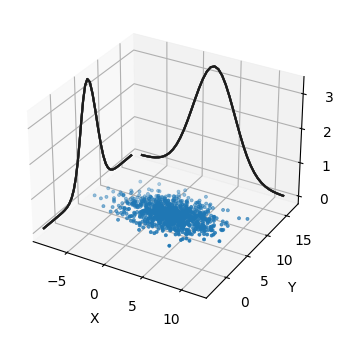

In [22]:
mkf_internal.plot_3d_sampled_covariance(mu, P)

我们可以将这些采样点看作是给定特定均值和协方差时狗可能出现的位置。侧面的等高线显示了 $X$ 和 $Y$ 的边际概率。我们可以看到，在 (2, 7) 有许多点的地方，狗更有可能出现，而在 (-5, 5) 几乎没有点，表示狗出现的可能性很低。

尽管这些图表十分美观，但要从中获取有用信息并不容易。例如，很难判断 $X$ 和 $Y$ 是否具有相同的方差，以及它们之间的相关程度。在本书的大部分内容中，我会将高斯分布显示为等高线图。

等高线图显示了多元高斯分布在特定标准差下所取值的范围。这就像从三维图中取出一个水平切片一样。

这些图展示了 3 个标准差下切片的形状。

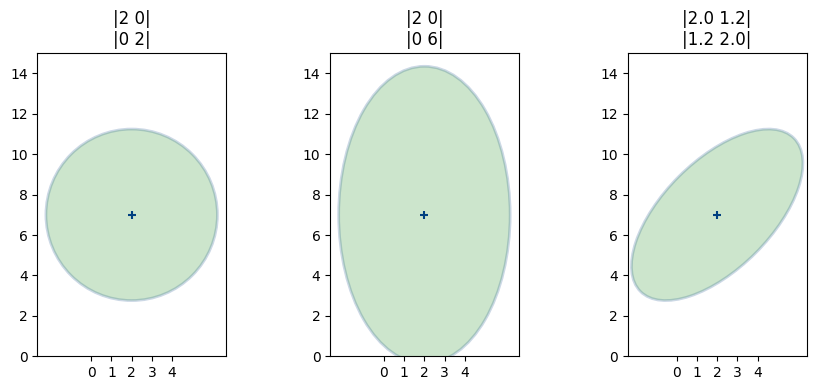

In [23]:
mkf_internal.plot_3_covariances()

对于在线或在您的计算机上使用 Jupyter Notebook 查看此内容的用户，这是一个动画，显示了在保持方差恒定的情况下改变协方差的过程。

<img src='animations/multivariate_ellipse.gif'>

(source: http://git.io/vqxLS)

这些图看起来像是圆形和椭圆形。事实上，通过多元高斯分布的任何切片都是一个椭圆。因此，在统计学中，我们不将其称为“等高线图”，而是称为*误差椭圆*或*置信椭圆*；这两个术语可以互换使用。

此代码使用了 `filterpy.stats` 中的 `plot_covariance_ellipse()` 函数。默认情况下，该函数显示一个标准差，但您可以使用 `variance` 或 `std` 参数来控制显示的内容。例如，`variance=3**2` 或 `std=3` 将显示第三个标准差，`variance=[1,4,9]` 或 `std=[1,2,3]` 将显示第一、第二和第三个标准差。

/tmp/ipykernel_4447/376262884.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.gca().grid(b=False);


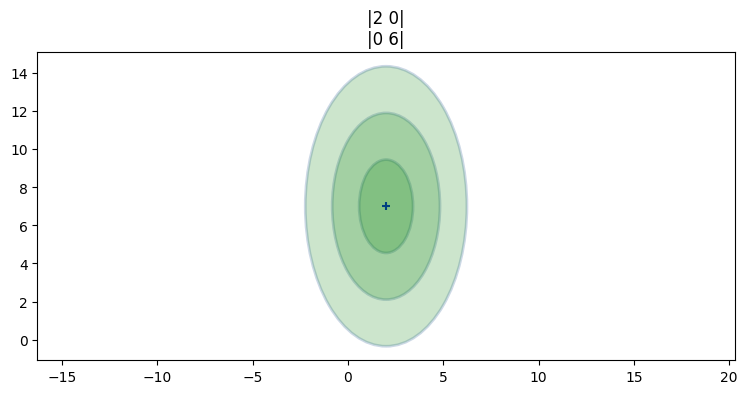

In [24]:
from filterpy.stats import plot_covariance_ellipse
import matplotlib.pyplot as plt

P = [[2, 0], [0, 6]]
plot_covariance_ellipse((2, 7), P, fc='g', alpha=0.2, 
                        std=[1, 2, 3],
                        title='|2 0|\n|0 6|')
plt.gca().grid(b=False);

实心颜色可能让您误以为在标准差之间概率分布是恒定的。事实并非如此，你可以从高斯分布的三维图中看出。这是协方差为 $\begin{smallmatrix}2&1.2\\1.2&1.3\end{smallmatrix}$ 的概率分布的二维阴影表示，较深的灰色对应着更高的概率密度。

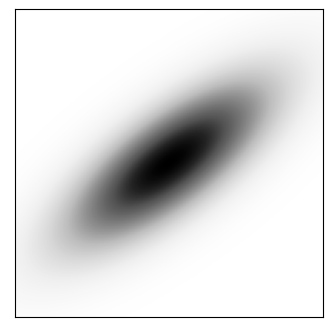

In [25]:
from kf_book.nonlinear_plots import plot_cov_ellipse_colormap
plot_cov_ellipse_colormap(cov=[[2, 1.2], [1.2, 1.3]]);

思考这些图的物理解释能够澄清它们的含义。第一个图的均值和协方差是

$$
\mathbf{\mu} =\begin{bmatrix}2\\7\end{bmatrix},\, \,
\Sigma = \begin{bmatrix}2&0\\0&2 \end{bmatrix}
$$

/tmp/ipykernel_4447/4053888375.py:5: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.gca().grid(b=False)


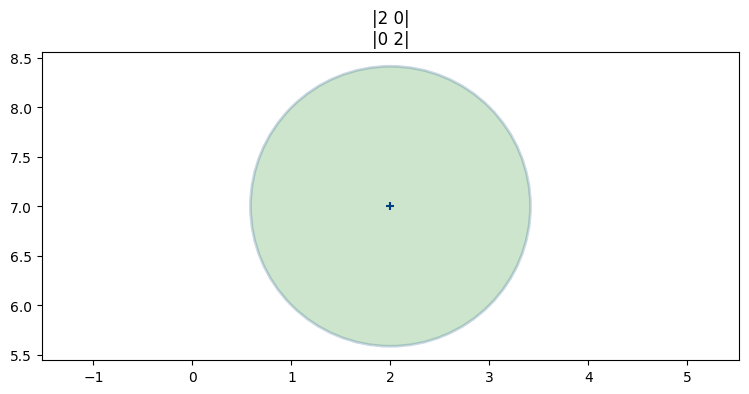

In [26]:
x = [2, 7]
P = [[2, 0], [0, 2]]
plot_covariance_ellipse(x, P, fc='g', alpha=0.2, 
                       title='|2 0|\n|0 2|')
plt.gca().grid(b=False)

用贝叶斯的思维方式来理解，椭圆向我们展示了我们信念中的误差量。一个小圆圈表示我们有很小的误差，而一个非常大的圆圈表示我们的信念中有很大的误差。椭圆的形状向我们展示了 $X$ 和 $Y$ 中误差的几何关系。在这里，我们有一个圆圈，因此 $X$ 和 $Y$ 中的误差同等可能。

第二个图的均值和协方差是：

$$
\mu =\begin{bmatrix}2\\7\end{bmatrix}, \, \, \, 
\Sigma = \begin{bmatrix}2&0\\0&6\end{bmatrix}
$$

/tmp/ipykernel_4447/1367993942.py:5: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.gca().grid(b=False)


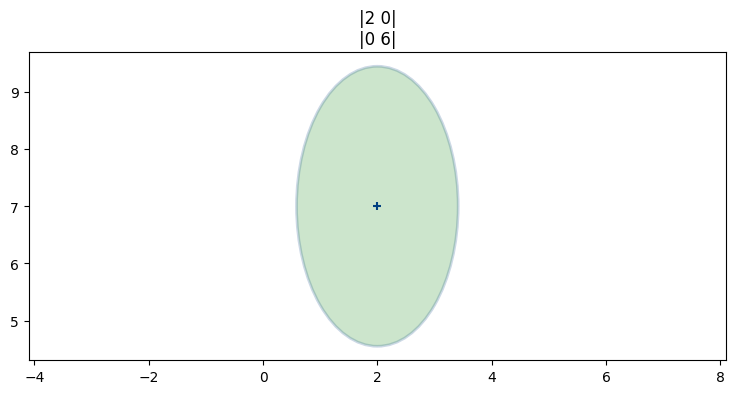

In [27]:
x = [2, 7]
P = [[2, 0], [0, 6]]
plot_covariance_ellipse(x, P, fc='g', alpha=0.2, 
                    title='|2 0|\n|0 6|')
plt.gca().grid(b=False)

这次我们使用了不同的方差，$X$ 的方差为 $\sigma_x^2=2$，$Y$ 的方差为 $\sigma^2_y=6$。结果是一个高瘦的椭圆。我们可以看到在 $Y$ 方向上的不确定性比 $X$ 方向上要大得多。在两种情况下，我们都相信狗在 (2, 7) 的位置，但不确定性是不同的。

第三个图显示的均值和协方差是：

$$
\mu =\begin{bmatrix}2\\7\end{bmatrix}, \, \, \, 
\Sigma = \begin{bmatrix}2&1.2\\1.2&2\end{bmatrix}
$$

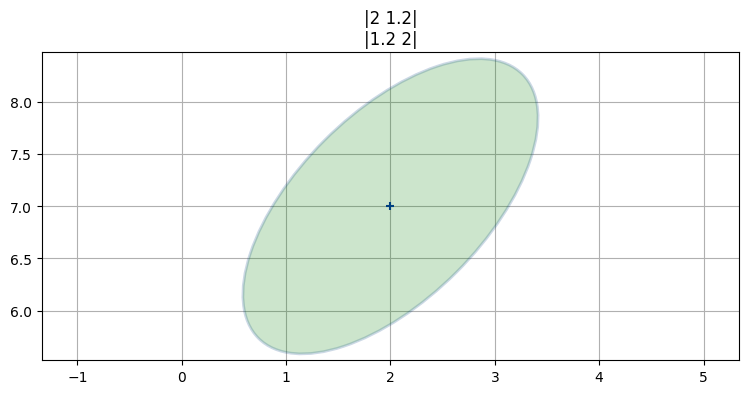

In [28]:
x = [2, 7]
P = [[2, 1.2], [1.2, 2]]
plot_covariance_ellipse(x, P, fc='g', alpha=0.2, 
                    title='|2 1.2|\n|1.2 2|')

这是第一个具有协方差矩阵非对角元素值的等高线图，并且这是第一个斜椭圆的等高线图。这不是巧合。这两个事实告诉我们同样的事情。一个斜椭圆告诉我们 $x$ 和 $y$ 的值在某种程度上是相关的。协方差矩阵中的非对角元素是非零的，表明存在相关性。

回想一下身高与体重的图表。它形成了一组斜着排列的点。我们可以使用 NumPy 的 `cov()` 函数通过将它们放入 2D 数组中来计算两个或多个变量的协方差。让我们这样做，然后在数据上绘制 $2\sigma$ 的协方差椭圆。我们需要使用 `bias=1`，因为数据代表的是整个总体；它不是一个样本。

In [29]:
cov_hw = np.cov(np.vstack((height, weight)), bias=1)
cov_hw

array([[  18.5249,  135.701 ],
       [ 135.701 , 1092.29  ]])

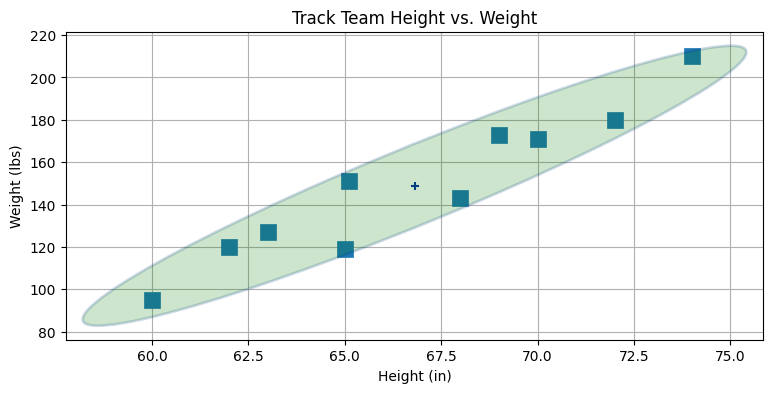

In [30]:
plt.scatter(height, weight, s=120, marker='s')
plt.title('Track Team Height vs. Weight')
plt.xlabel('Height (in)'); plt.ylabel('Weight (lbs)')
plot_covariance_ellipse((np.mean(height), np.mean(weight)), cov_hw, fc='g', 
                        alpha=0.2, axis_equal=False, std=2)

这应该帮助你对协方差的含义和用途形成强烈的直觉认识。协方差椭圆向你展示了数据之间的“分散”程度。这样的狭窄椭圆告诉你数据之间的相关性很高。对于任何给定的身高，体重的范围很窄。椭圆向右倾斜，告诉我们存在正相关性 - 当 $x$ 增加时，$y$ 也增加。如果椭圆向左倾斜，那么相关性就是负相关的 - 当 $x$ 增加时，$y$ 减少。我们可以在接下来的图中看到这一点：

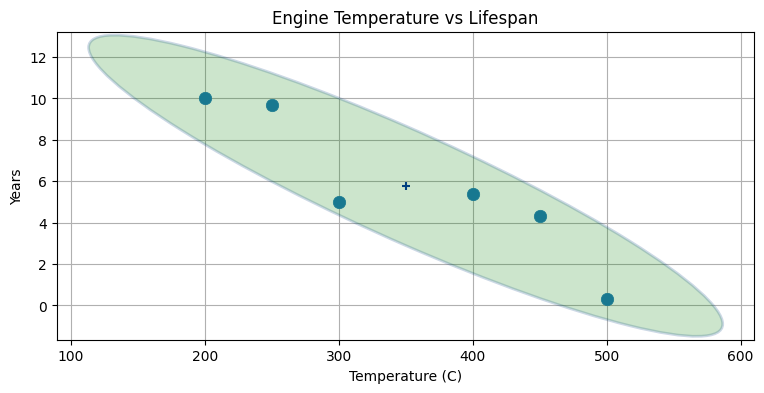

In [31]:
max_temp = [200, 250, 300, 400, 450, 500]
lifespan = [10, 9.7, 5, 5.4, 4.3, 0.3]

plt.scatter(max_temp, lifespan, s=80)
cov = np.cov(np.vstack((max_temp, lifespan)))
plot_covariance_ellipse((np.mean(max_temp), np.mean(lifespan)), cov, fc='g', 
            alpha=0.2, axis_equal=False, std=2)
plt.title('Engine Temperature vs Lifespan')
plt.xlabel('Temperature (C)'); plt.ylabel('Years');

方差和协方差之间的关系可能不容易通过简单的观察理解，因此这里提供了一个交互式图表。（如果你是在静态形式下阅读这段话，可以点击这里的链接查看在线运行的说明：https://git.io/vza7b）

In [32]:
from ipywidgets import interact
from kf_book.book_plots import figsize, FloatSlider

fig = None
def plot_covariance(var_x, var_y, cov_xy):
    global fig
    if fig: plt.close(fig)
    fig = plt.figure(figsize=(4,4))
    P1 = [[var_x, cov_xy], [cov_xy, var_y]]

    plot_covariance_ellipse((10, 10), P1, axis_equal=False,
                            show_semiaxis=True)

    plt.xlim(4, 16)
    plt.gca().set_aspect('equal')
    plt.ylim(4, 16)

    
with figsize(y=6):
    interact (plot_covariance,           
          var_x=FloatSlider(5, min=0, max=20), 
          var_y=FloatSlider(5, min=0, max=20), 
          cov_xy=FloatSlider(1.5, min=0, max=50, step=.2));

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='var_x', max=20.0), FloatSli…

# 皮尔逊相关系数

本书不会使用这个系数，但你可能在其他地方会见到它。如果对此不感兴趣，可以跳过这一部分。

两个变量之间的相关性可以用*皮尔逊相关系数*给予一个数值。它的定义是：

$$\rho_{xy} = \frac{COV(X, Y)}{\sigma_x \sigma_y}$$

这个值的范围是从 -1 到 1。如果协方差为 0，则 $\rho=0$。大于 0 的值表示正相关关系，而负值表示负相关。接近 -1 或 1 的值表示非常强的相关性，接近 0 的值表示非常弱的相关性。

相关性和协方差密切相关。协方差具有与之相关的单位，而相关性是一个无单位的比率。比如，对于我们的狗 $\sigma_{xy}$ 的单位是平方米。

我们可以使用 `scipy.stats.pearsonr` 函数来计算皮尔逊相关系数。它返回一个元组，包含了皮尔逊系数和双尾检验的 p 值。在本书中，我们不会使用后者。这里我们计算运动员的身高与体重之间的 $\rho$：

In [33]:
from scipy.stats import pearsonr
pearsonr(height, weight)[0]

0.9540

在此，我们计算了发动机温度与使用寿命之间的相关性。

In [34]:
pearsonr(max_temp, lifespan)[0]

-0.9178

# 利用相关性改进估计

假设我们认为我们的狗位于位置（5，10），具有某个给定的协方差。如果x和y方向上的标准差都为2米，但它们之间存在很强的相关性，那么协方差轮廓可能会呈现这样的形状。

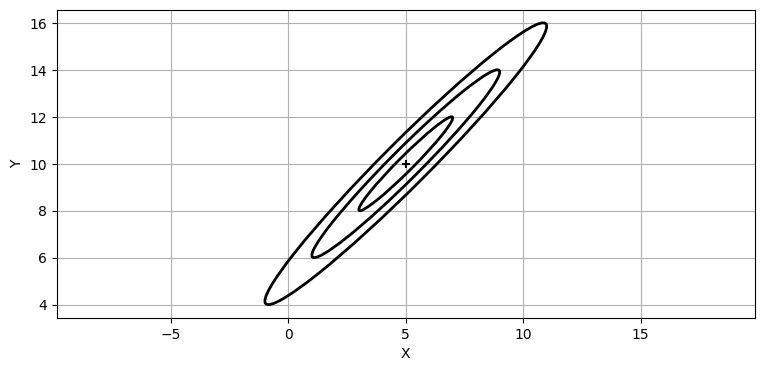

In [35]:
P = [[4, 3.9], [3.9, 4]]

plot_covariance_ellipse((5, 10), P, ec='k', std=[1, 2, 3])
plt.xlabel('X')
plt.ylabel('Y');

现在假设我告诉你$x=7.5$。我们可以推断$y$的值吗？这个位置极有可能位于3$\sigma$协方差椭圆内。根据协方差矩阵，我们可以推断*y*的位置，因为*x*和*y*之间存在相关性。我用蓝色填充的圆圈表示了*y*的可能值范围。

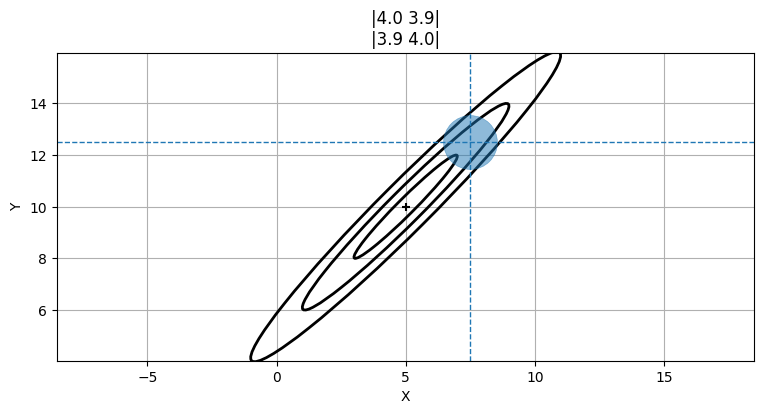

In [36]:
mkf_internal.plot_correlation_covariance()

这个圆圈在数学上不是完全正确的，但它传达了这个概念。我们将在下一节解决数学问题。现在要认识到，我们可以预测*y*可能接近12。而*y=-10*的值几乎不可能。

关于*相关性*和*独立性*要说一句。如果变量是*独立的*，它们可以分别变化。比如在开阔的田野里行走，你可以向$x$方向（东西方向）、$y$方向（南北方向），或者它们的任意组合移动。独立的变量总是*无相关*的。除非在特殊情况下，反过来并不成立。变量可以是无相关的，但是是有依赖关系的。例如，考虑$y=x^2$。相关性是线性度量，所以$x$和$y$是无相关的。然而，$y$却依赖于$x$。

# 多维高斯乘法

在上一章中，我们通过将不确定的测量与不确定的估计相乘，将它们的高斯分布结合在一起。结果是具有较小方差的另一个高斯分布。如果两个不确定信息互相印证，我们对结论应该更有把握。图形看起来是这样的：

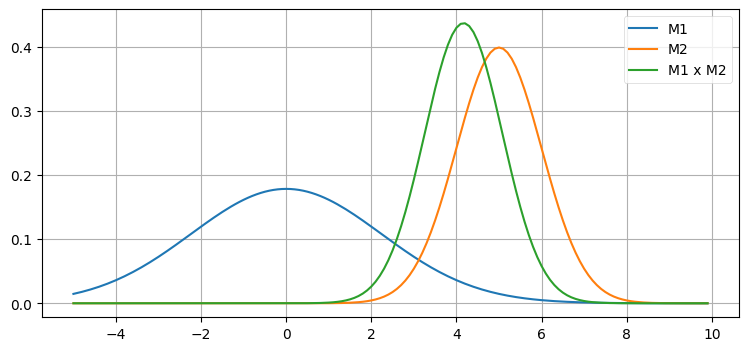

In [37]:
mkf_internal.plot_gaussian_multiply()

综合测量 1 和 2 带来更大的确定性，所以新的高斯分布更高更窄 - 方差变小了。在多维度中，多元高斯分布也是如此。

这是乘法多元高斯分布的方程。大写的 sigma（$\Sigma$）表示这些是矩阵，而不是标量。具体来说，它们是协方差矩阵：

$$\begin{aligned}
\mu &= \Sigma_2(\Sigma_1 + \Sigma_2)^{-1}\mu_1 + \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}\mu_2 \\
\Sigma &= \Sigma_1(\Sigma_1+\Sigma_2)^{-1}\Sigma_2
\end{aligned}$$

它们是通过将先验和估计的多元高斯分布代入贝叶斯定理而生成的。我在**Gaussians**章节中给出了一元情况的代数公式。

你不需要记住这些公式，因为它们是由稍后将介绍的卡尔曼滤波器方程计算出来的。这个计算也可以在 FilterPy 中使用 `filterpy.stats` 中的 `multivariate_multiply()` 方法来完成。

为了让你对此有一些直观认识，回想一下乘法单变量高斯分布的方程：

$$\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

这看起来与多元方程的方程相似。如果你意识到矩阵求逆，用 -1 表示，就类似于一个倒数，因为 $AA^{-1} =I$。我将求逆表示为除法 - 这并不是数学上正确的操作，因为矩阵除法是没有定义的，但这有助于我们比较方程。

$$\begin{aligned}
\mu &\approx \frac{\Sigma_2\mu_1 + \Sigma_1\mu_2}{\Sigma_1 + \Sigma_2} \\ \\
\Sigma &\approx \frac{\Sigma_1\Sigma_2}{(\Sigma_1+\Sigma_2)}
\end{aligned}$$

以这种形式，一元和多元方程之间的关系就变得清晰了。

现在让我们通过一个具体的例子来探讨多元高斯分布。假设我们正在跟踪一架飞机，使用两个雷达系统。我会忽略高度，这样我就可以使用二维图。雷达提供到目标的距离和方位。我们开始对飞机的位置不确定，因此，协方差，也就是我们对位置的不确定性，可能看起来像这样。在贝叶斯统计的术语中，这就是我们的*先验*。

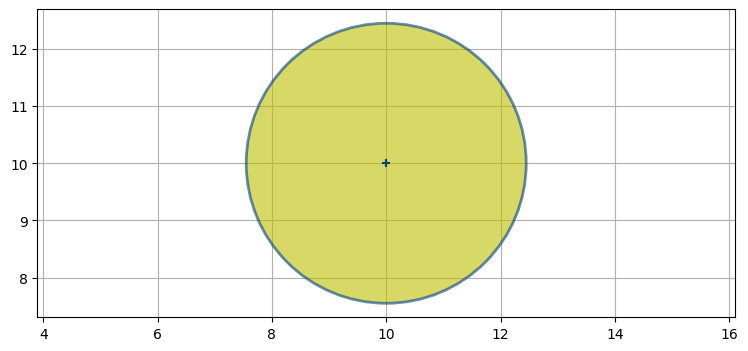

In [38]:
P0 = [[6, 0], [0, 6]]
plot_covariance_ellipse((10, 10), P0, fc='y', alpha=0.6)

现在假设飞机左下方有一个雷达。进一步假设雷达的方位测量准确，但距离测量不准确。测量误差的协方差可能看起来像这样（在黄色先验上绘制了绿色的图）。

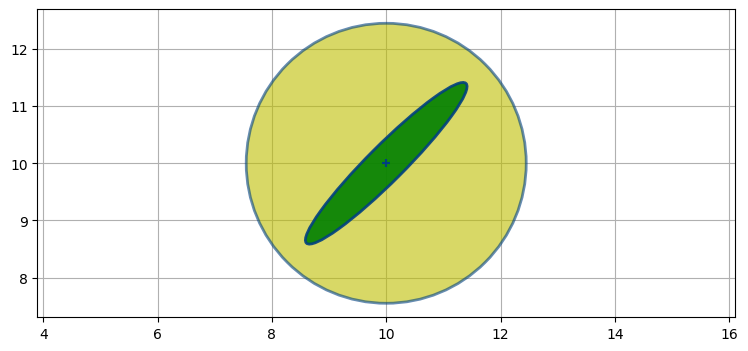

In [39]:
P1 = [[2, 1.9], [1.9, 2]]
plot_covariance_ellipse((10, 10), P0, fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P1, fc='g', alpha=0.9)

贝叶斯统计称这个为“证据”。椭圆指向雷达。它非常长，因为距离测量不准确，飞机可能在测量范围的相当远处。它非常窄，因为方位估计非常准确，因此飞机必须非常接近方位估计。

我们希望找到“后验”——将证据合并到先验中得出的平均值和协方差。就像在其他章节中一样，我们通过将它们相乘来结合证据。

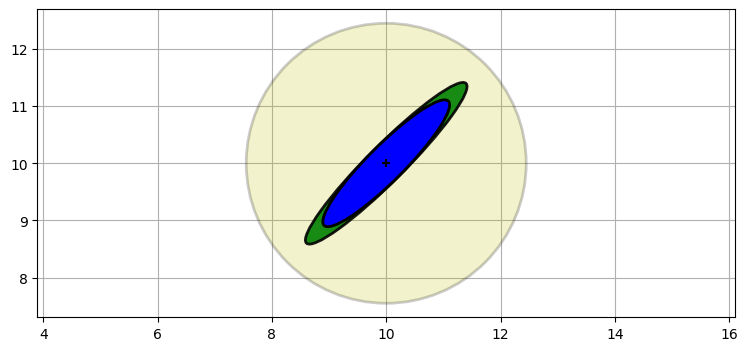

In [40]:
from filterpy.stats import multivariate_multiply

P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
plot_covariance_ellipse((10, 10), P0, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P1, ec='k', fc='g', alpha=0.9)
plot_covariance_ellipse((10, 10), P2, ec='k', fc='b')

我用非常透明的黄色绘制了原始估计（先验），用绿色表示雷达读数（证据），用蓝色表示最终估计（后验）。

后验保留了雷达测量的形状和位置，但是它更小。我们在一维高斯分布中已经看到了这一点。将两个高斯分布相乘会使方差变小，因为我们融合了更多信息，因此我们变得更加确定。另一个要注意的点是，协方差的形状反映了飞机和雷达系统的物理布局。这一点的重要性将在下一步变得清晰。

现在假设我们从第二个雷达得到了测量数据，这个雷达位于右下方。上一步得到的后验成为我们的新先验，我用黄色绘制了它。新的测量数据用绿色表示。

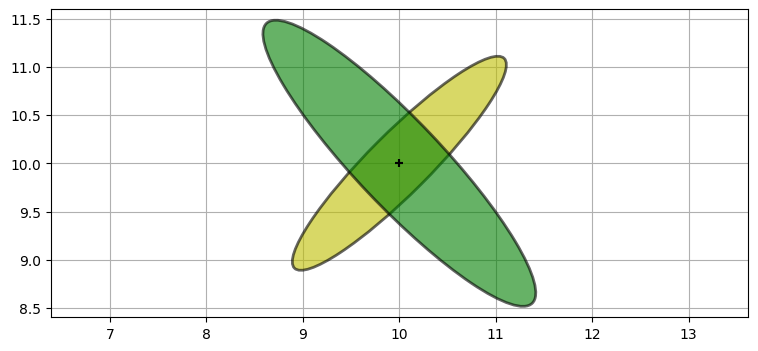

In [41]:
P3 = [[2, -1.9], [-1.9, 2.2]]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)

我们通过高斯乘法将这一信息纳入其中：

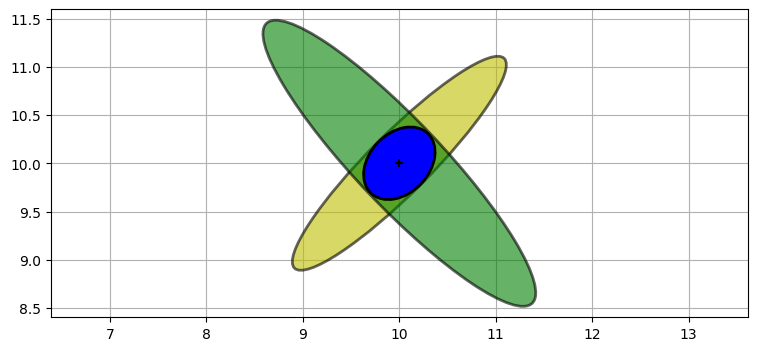

In [42]:
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P4, ec='k', fc='b')

在飞机可能出现的唯一位置是两个椭圆相交的地方。由先验和测量值相乘形成的交集是一个新的高斯分布。这些形状反映了问题的几何特征。这使我们能够对飞机进行三角定位，从而得出非常精确的估计。我们没有显式地编写任何代码来执行三角定位；它是将每次测量的高斯分布相乘的自然结果。

回想一下“g-h Filter”章节，我们在天平上显示了两次称重的误差范围。估计值必须落在误差范围重叠的区域内。在这里，估计值必须在161到163磅之间。

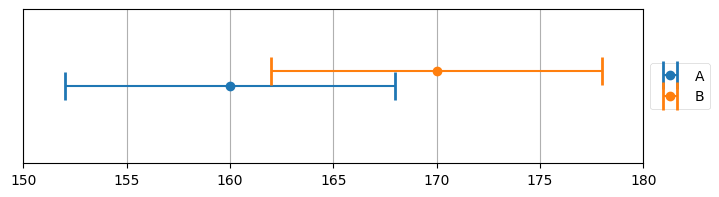

In [43]:
import kf_book.book_plots as book_plots
book_plots.plot_errorbars([(160, 8, 'A'), (170, 8, 'B')], xlims=(150, 180))

让我们考虑一个不同的布局。假设第一个雷达就在飞机的左边。我可以用以下测量误差来建模：
$$\Sigma = \begin{bmatrix}2&0\\0&0.2\end{bmatrix}$$

这里我们看到先验与测量结果相乘的效果。

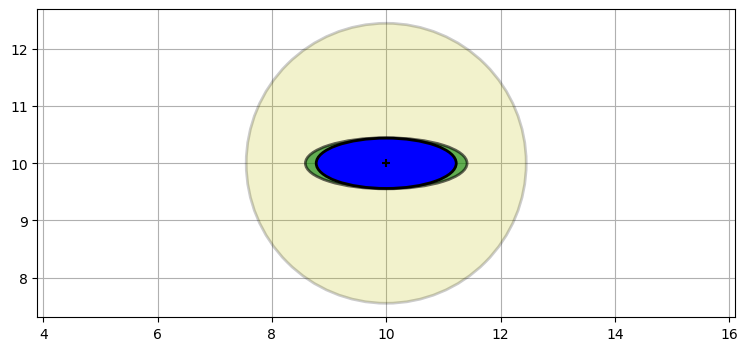

In [44]:
P1 = [[2, 0], [0, .2]]
P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
plot_covariance_ellipse((10, 10), P0, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P1, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P2, ec='k', fc='b')

现在我们可以加入第二个雷达系统的测量，我们将其保持在之前的相同位置。

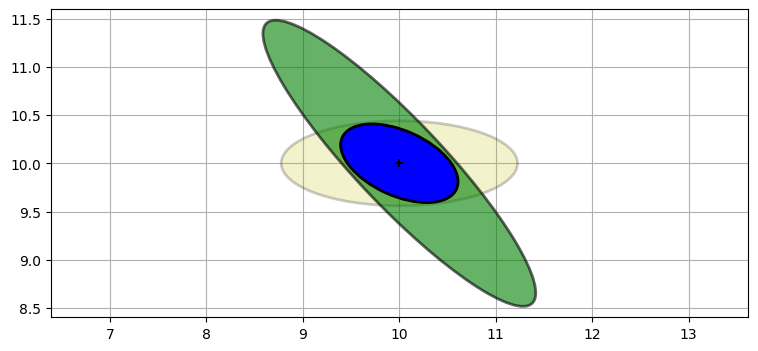

In [46]:
P3 = [[2, -1.9], [-1.9, 2.2]]
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P4, ec='k', fc='b')

对于最后一个例子，想象一下在短时间内从同一个雷达获取两个测量。协方差椭圆将几乎重叠，导致我们的新估计具有非常大的误差：

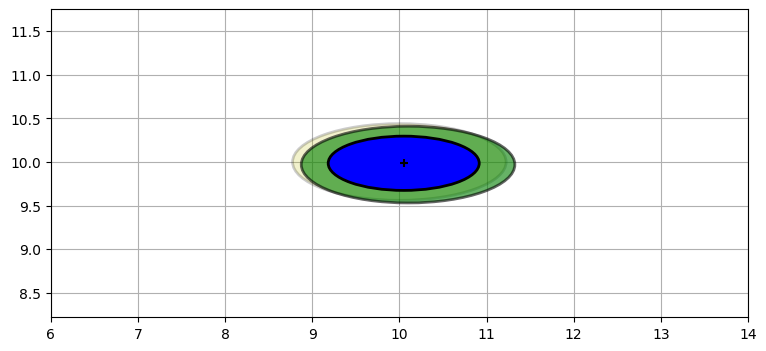

In [47]:
P5 = multivariate_multiply((10,10), P2, (10.1, 9.97), P2)
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10.1, 9.97), P2, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse(P5[0], P5[1], ec='k', fc='b')
plt.xlim(6, 14);

# 隐藏变量

你已经可以看出为什么多元卡尔曼滤波器比单元的效果更好了。变量之间的相关性可以显著改善我们的估计。我们可以更进一步。**本节包含了这一章的关键内容，所以请仔细阅读**。

假设我们正在跟踪一架飞机，并且我们得到了$t$=1、2和3秒时$x$和$y$坐标的以下数据。根据你的直觉，你觉得$t$=4秒时的$x$值会是多少？

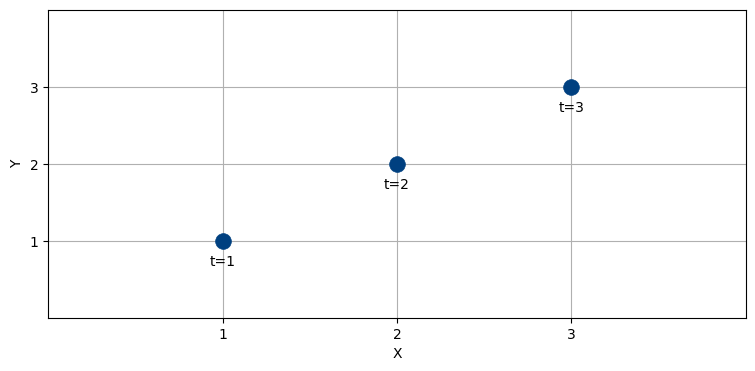

In [48]:
mkf_internal.show_position_chart()

看起来飞机是直线飞行的，而我们知道飞机不可能突然转弯。最合理的猜测是在$t$=4时，飞机位于(4,4)处。我会用一个绿色箭头表示出来。

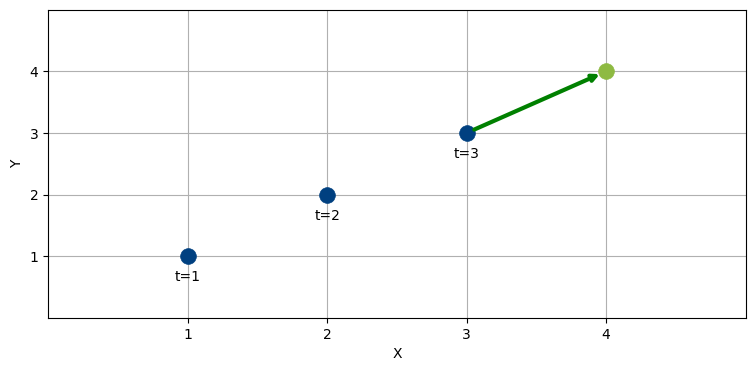

In [49]:
mkf_internal.show_position_prediction_chart()

你作出了这个推断，是因为你*推断*了飞机的恒定速度。合理的假设是飞机每个时间步在*x*和*y*方向上各移动一个单位。

回想一下**g-h滤波器**章节，当时我们试图改进嘈杂的天平的重量预测。我们将*重量增加*纳入了方程，因为这可以让我们更好地预测第二天的重量。g-h滤波器使用$g$参数来缩放当前重量测量的重要性，而$h$参数则缩放了给予重量增加的重要性。

我们将用同样的方式使用我们的卡尔曼滤波器。毕竟，卡尔曼滤波器是g-h滤波器的一种形式。在这种情况下，我们正在追踪一架飞机，所以我们需要跟踪位置和速度，而不是重量和重量增加。重量增加是重量的*导数*，当然，速度是位置的导数。我们无法绘制和理解需要绘制*x*和*y*及其各自速度的四维图表，因此让我们先看看$x$，知道这个数学可以推广到更多维度。

在时刻1，我们对位置（x=0）可能相当有把握，但对速度一无所知。我们可以用类似这样的协方差矩阵来表示。较窄的宽度表示了我们对位置的相对确定性，而较高的高度则表示了我们对速度的不了解。

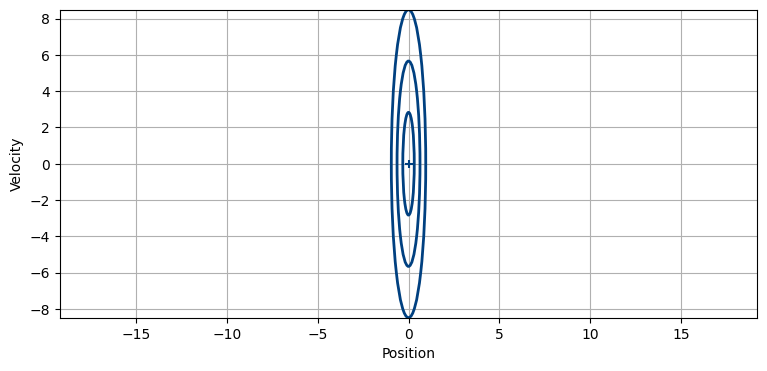

In [50]:
mkf_internal.show_x_error_chart(1)

然而，位置和速度是相关的。如果速度是5米/秒，那么1秒后的位置将是5米。如果速度是-10米/秒，那么1秒后的位置将是-10米。让我们用对角线上的速度协方差来可视化这一点。

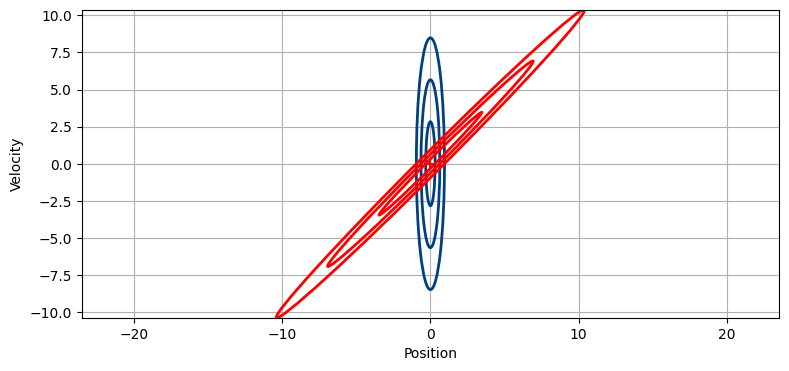

In [51]:
mkf_internal.show_x_error_chart(2)

在这一点上，速度协方差对我们没有帮助。我们无法预测一个新的位置，因为我们不知道速度是多少。但是经过一秒钟，我们得到了一个x=5的位置更新。

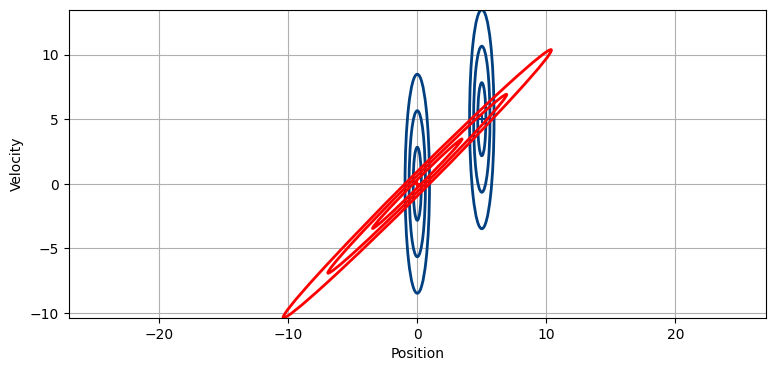

In [52]:
mkf_internal.show_x_error_chart(3)

在下一章之前，我如何计算接下来要说的内容还不清楚。忽略计算的部分，想一想这意味着什么。我们没有简单的方法来确定物体的确切位置，因为我们对速度非常不确定。因此，椭圆在 x 轴上延伸得很远。我们对速度的不确定性当然意味着它在 y 轴上也非常分散。但正如我在上一段中所说，位置与速度是相关的。如果速度是 5 米/秒，下一个位置将是 5，如果速度是 10，下一个位置将是 10。它们之间有很强的相关性，因此椭圆必须非常狭窄。

这两种协方差的叠加是奇迹发生的地方。在 t=1 时（位置=5），唯一合理的估计大致是速度协方差和测量协方差的交集！更准确地说，我们可以使用上一节的数学，将这两种协方差相乘。从贝叶斯的角度来看，我们将先验与证据的概率（*似然*）相乘得到后验。如果我们使用贝叶斯方程将位置协方差与速度协方差相乘，就会得到这个结果：

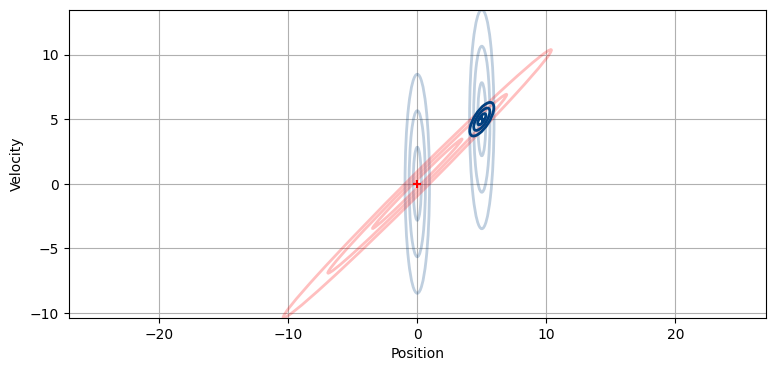

In [53]:
mkf_internal.show_x_error_chart(4)

新的协方差（后验）位于位置协方差和速度协方差的交集处。它略微倾斜，显示出位置和速度之间存在一定的相关性。更重要的是，它比位置或速度的协方差要小得多。在先前的章节中，每次执行“update（）”时，我们的方差都会变小，因为先前的估计值与新测量值相乘。在这里也是一样。然而，在这里改进显著得多。这是因为我们使用了两个不同但相关的信息。大致了解速度及其相关性以及大致了解位置使我们能够做出非常准确的估计。在这个图表中不容易看出来，但是位置的不确定性变小了。我们之所以知道这一点，是因为在 t=1 时，新的协方差在 x 轴上的范围不及测量协方差那么远。因此，我们不仅对速度更加确定，对于位置的确定性也更高，而如果仅使用位置测量而不考虑速度，我们对位置的确定性就不会这么高！

这是一个关键点，所以请仔细阅读！雷达只能检测飞机的位置。这被称为*观察变量*。基于位置估计，我们可以计算速度。我们称速度为*隐藏变量*。隐藏意味着字面上的意思 - 没有传感器测量速度，因此它的值对我们来说是隐藏的。我们能够利用位置和速度之间的相关性非常准确地推断其值。

为了完善术语，还有*未观察变量*。例如，飞机的状态包括诸如航向、发动机转速、重量、颜色、飞行员的名字等。我们不能直接使用位置传感器直接感知这些变量，因此它们不是*观察到的*。没有办法从传感器测量和相关性（红色飞机不会比白色飞机飞得更快）中*推断*它们的值，所以它们也不是*隐藏的*。相反，它们是*不可观测的*。如果在你的滤波器状态中包含了一个未观察变量，那么对于该变量的估计将是无意义的。

如果将来自不同飞机的速度与位置图形叠加在一起，它们之间是没有关联的，结合它们也不会提供额外的信息。但是，对于同一架飞机来说，速度告诉了我们关于飞行方向和速度的重要信息。只要飞机不改变速度，速度就能帮助我们预测下一个位置。

若速度存在一定的误差，当速度与位置相匹配时，这个匹配的概率会变得非常小。如果飞机突然改变方向，位置也会随之改变很多。如果测量的位置与速度变化的方向不一致，那么这个测量结果很可能是错误的。因为速度和位置之间是相关的，所以速度的变化会带来位置的变化，并且这种变化是可以预测的。

利用速度和位置之间的相关性，我们可以从两次测量中获得速度的粗略估计，并通过贝叶斯定理得出非常准确的估计值。这种相关性的利用对于提高对飞行状态的准确预测至关重要。

# 更高的维度

到目前为止，我展示了二维高斯分布，但数学并不限制你只能使用两个维度。在后面的章节中，我们可能会使用 9 或者甚至 12 个维度。如果你在像天气预测这样的领域工作，可能会涉及成千上万个维度。

那么这些更高维度是什么样子的呢？嗯，一个二维高斯分布可以用一个误差椭圆来表示，因此可以推断一个三维高斯分布可以用一个三维的误差椭球来表示。我们不会在这里深入讨论数学，但事实证明这是正确的。`FilterPy`提供了一个函数来绘制这个椭球。

首先，让我们制造一些具有给定协方差的噪声数据，这样我们就可以在椭球内部绘制它。


In [54]:
from filterpy.stats import plot_3d_covariance

mu = [0.3, 5., 10.]
C = np.array([[1.0, .03, .2],
              [.03,  4.0, .0],
              [.2,  .0, 16.1]])

sample = np.random.multivariate_normal(mu, C, size=1000)

现在我们使用`FilterPy`中的`plot_3d_covariance`函数绘制椭球，然后对样本进行散点图绘制。

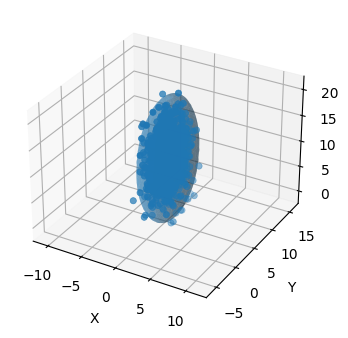

In [56]:
ax = plot_3d_covariance(mu, C, alpha=.4, std=3, limit_xyz=True)
ax.scatter(sample[:, 0], sample[:, 1], zs=sample[:, 2],);

理论指出，大约 99% 的分布数据会落在 3 个标准差范围内，这个规律似乎也是成立的。

九个维度？我还没搞清楚如何在二维屏幕上绘制一个九维椭球，所以无法提供图形。但概念是一样的；分布的标准差误差可以用一个九维椭球来描述。

# 总结

我们利用系统的几何结构和相关性来产生非常准确的估计。数学并不关心我们是在处理两个位置，还是一个位置和一个相关的速度，或者这些是空间维度。如果房屋空间与房价相关，你可以编写卡尔曼滤波器来跟踪房价。如果年龄与疾病发病率相关，你可以编写卡尔曼滤波器来跟踪疾病。如果僵尸人口与猎枪数量呈反相关，那么你可以编写卡尔曼滤波器来跟踪僵尸人口。我用几何术语展示了这一点，并谈到了*三角定位*，那只是为了建立你的直觉。你可以为没有几何表示的状态变量编写卡尔曼滤波器，比如股票价格或牛奶产量的过滤器（我收到过一个追踪牛奶产量的邮件！）。习惯将这些看作具有相关性的高斯分布。如果我们能将不确定性表达为多维高斯分布，那么我们就能将先验与似然相乘，得到更加准确的结果。

# 参考

- [1] http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html

- [2] `FilterPy` library. Roger Labbe.
https://github.com/rlabbe/filterpy